In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import datetime
import string
from string import digits
import collections
import scipy.stats as scs
import cc_pipeline as P
import time
import random
import pickle
from pprint import pprint
from collections import Counter

#sentiment and language
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import vaderSentiment
from langdetect import detect
from gensim.models import Word2Vec
from gensim import corpora
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from spacy import displacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF, LatentDirichletAllocation
from gensim.models.ldamodel import LdaModel
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2
import knee_locator

#plotting
from bokeh.plotting import figure, show, output_file, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, BoxSelectTool
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import pyLDAvis.sklearn
import pyLDAvis.gensim as gensimvis
import pyLDAvis
import umap

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

def scrape_text(series):
    
    #use pd.series instead moving forward
    text = []
    for link in series:
        
        try:
            req = Request(link, headers={'User-Agent': 'Mozilla/5.0'})
            webpage = urlopen(req).read()
            webpage = webpage.decode('utf-8')
            text.append(webpage)
        except SocketError as e:
            if e.errno != errno.ECONNRESET:
                raise # Not error we are looking for
            pass # Handle error here.
        
    return text

def scrape_from_url(cycles):
    
    for i in range(cycles):
        
        time.sleep(900)
        
        from_df = pd.read_csv('data/cc_recent.csv', encoding='utf-8')
        temp_df = from_df.head(1000)

        #scrape text then concat
        text_url_series = pd.Series(temp_df['url'])
        extracts = scrape_text(text_url_series)
        extracts = pd.Series(extracts)
        temp_df['text'] = extracts

        head_df = pd.read_csv('data/cc_head_text.csv', encoding='utf-8')
        head_df = pd.concat([head_df, temp_df])
        head_df.to_csv('data/cc_head_text.csv', encoding='utf-8', index=False)

        from_df = from_df.drop(from_df.index[0:1000])
        from_df.to_csv('data/cc_recent.csv', encoding='utf-8', index=False)

        head_df=None
        temp_df=None
        from_df=None
        text_url_series=None
        extracts=None
        


In [ ]:
#scrape_from_url(1)

In [ ]:
#clean text

def get_show_text(show_raw):
    
    '''returns show text without timestamps'''
    
    return "\n".join( ["\n".join( x.split("\n")[2:] ) for x in show_raw.split("\n\n")] )



def clean_all_text(text_list):
    
    '''cleans all text and creates new column in dataframe'''
    
    doc_list = []
    for word in text_list:
        doc_list.append(get_show_text(word))
    return doc_list


def clean_text(doc):
    '''cleans and lemmatizes a string by removing punc, characters, digits, and len(words) < 3'''
    
    stop_words = stopwords.words('english')
    punct = ('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~♪¿’')
    remove_digits = str.maketrans('', '', digits)
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = []
    
    doc = doc.split('\n')
    doc = ' '.join(doc)
    doc = doc.split('-')
    doc = ' '.join(doc)
    doc = doc.split('...')
    doc = ' '.join(doc)
    doc = word_tokenize(doc)

    a = [char for char in doc if char not in punct]
    b = [w for w in a if w not in stop_words] 
    c = [w for w in b if len(w) > 3]
    d = [x for x in c if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]

    e = ' '.join(d)
    f = e.lower()
    g = f.translate(remove_digits)
    cleaned = str(g)
    doc = word_tokenize(cleaned)
    
    for val in doc:
        doc_temp = wordnet_lemmatizer.lemmatize(val)
        lemmatized.append(doc_temp)
    doc = ' '.join(lemmatized)
    
    return doc

def clean_and_return(docs_list):
    
    docs = []
    for cc in docs_list:
        cleaned_temp = clean_text(cc)
        docs.append(cleaned_temp)
        
    return docs


def lang_detect(doc_series):
    
    lang = []
    for x in doc_series:
        eng = 'en'
        span = 'es'

        try:
            if detect(x) == eng:
                lang.append(eng)
            else:
                lang.append(span)
        except:
            lang.append(None)
            
    return lang


def remove_words(word_list):
    
    remove = ['list', 'of', 'throw-away', 'words']
    
    return [w for w in word_list if w not in remove]

In [ ]:
temp_df = pd.read_csv('data/cc_1000_text.csv', encoding='utf-8')
temp_df.describe()

In [ ]:
temp = temp_df['text'].values
temp = temp.tolist()
type(temp)

In [ ]:
docs_list = clean_all_text(temp)
type(docs_list)

In [ ]:
cleaned_list = clean_and_return(docs_list)

In [ ]:
temp_df['cleaned'] = cleaned_list
temp_df.head(1)

In [ ]:
doc_series = pd.Series(temp_df['cleaned'].values)
language = lang_detect(doc_series)
temp_df['language'] = language
english = temp_df[temp_df['language'] == 'en']
spanish = temp_df[temp_df['language'] == 'es']

#english.to_csv('data/english.csv', encoding='utf-8', index=False)
#spanish.to_csv('data/spanish.csv', encoding='utf-8', index=False)

## Text Analysis

In [2]:
english = pd.read_csv('data/testenglish.csv', encoding='utf-8')
english.head(1)

,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url,date,text,cleaned,language
0,{'$oid': '5bb2b5082c1ba60007fc013d'},WBNX_HD_CW,{'$date': '2018-10-02T00:00:08.982Z'},900000,dflt,ENSWERCCR7_8_3,{'$numberLong': '1538437500000'},251536767,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:08.982,1538437621406\n1835\n[ KNOCK ON DOOR ]\n\n1538...,knock door knew only that still knock have doo...,en


In [33]:
def inline_text(show_raw):
    
    '''returns show text without timestamps'''
    
    temp = " ".join( ["\n".join( x.split("\n")[2:] ) for x in show_raw.split("\n\n")] )
    temp = temp.split('\n')
    temp = " ".join(temp)
    return temp

def clean_for_spacy(text_list):
    
    '''cleans all text and creates new column in dataframe'''
    
    doc_list = []
    for word in text_list:
        doc_list.append(inline_text(word))
    return doc_list

In [4]:
text = english['cleaned'].values
text = text.tolist()

pre = english['text'].values
pre = clean_for_spacy(pre)

In [24]:
pre[0]

'[ KNOCK ON DOOR ] HEY, DAD. SON. KNEW IT WAS YOU. YOU’RE THE ONLY ONE THAT STILL KNOCKS. WE HAVE A DOORBELL. OH, FORGIVE ME FOR TRYING TO SAVE YOU A COUPLE OF BUCKS ON ELECTRICITY. I LEFT MY NICOTINE GUM HERE THE OTHER NIGHT. I REALLY NEED IT SINCE I SWITCHED TO THOSE LIGHT CIGARETTES. SO THAT’S WHAT THAT IS. I THOUGHT IT WAS A CHICLET THAT HAD GONE BAD. EXPLAINS WHY I COULDN’T STOP CHEWING IT. IT’S A PRETTY GOOD GAME. WANT TO STICK AROUND AND WATCH? I GUESS. YOU KNOW, THE OTHER NIGHT, WHEN I WAS TALKING ABOUT SPANKING, I THINK YOU MIGHT HAVE TAKEN ME THE WRONG WAY. YOU WERE PRETTY CLEAR. I HIT YOU TOO MUCH. OPEN THAT, WOULD YOU? LOOK...YOU SPANKED US AND WE KNEW WHY. YOU KNOW, YOU NEVER TOOK IT TOO FAR, DAD. WELL, I WASN’T GIVING YOU MY FASTBALL. I’M JUST SAYING IT WAS NOTHING WE DIDN’T DESERVE. KIDS SHOULDN’T BE THROWING EACH OTHER OUT WINDOWS, LIGHTING EACH OTHER ON FIRE, OR STEALING A CAR. YOU STOLE MY CAR? THAT’S HOW WE GOT THE DENT IN THE BONNEVILLE? NO, NO. THAT’S WHERE JIMMY L

,duration,tui
count,51973.0,5.197300e+04
mean,900000.0,2.547169e+08
std,0.0,2.127712e+07
min,900000.0,2.515332e+08
25%,900000.0,2.515362e+08
50%,900000.0,2.515387e+08
75%,900000.0,2.515463e+08
max,900000.0,4.106483e+08


In [32]:
def vectorize_text(doc_list):
    
    vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), lowercase=True) 
    tfidf_model = vectorizer.fit_transform(doc_list)
    
    return tfidf_model

    
def svd(doc_list):
    
    model = vectorize_text(doc_list)
    
    svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
    clf = svd.fit_transform(model) 
    
    return clf

def find_elbow(doc_list):
    
    clf = svd(doc_list)
    
    distortions = []
    K = range(1,100,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, n_jobs=-1)
        kmeanModel.fit(clf)
        distortions.append(sum(np.min(cdist(clf, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / clf.shape[0])

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

def KMeans_PCA_plot(doc_list, num_clusters=3, n_jobs=4):
    
    clf = svd(doc_list)
    
    km = KMeans(n_clusters=num_clusters, n_jobs=4) 
    km.fit(clf)

    clusters = km.labels_.tolist()

    pca = PCA(n_components=2).fit(clf)
    data2D = pca.transform(clf)
    plt.scatter(data2D[:,0], data2D[:,1], c=clusters, alpha=0.1)

    centers2D = pca.transform(km.cluster_centers_)

    plt.scatter(centers2D[:,0], centers2D[:,1], 
                marker='x', s=200, linewidths=3, c='r')
    plt.title('(SVD REDUCED) Kmeans Clusters')
    plt.show() 

## TFIDF - Kernel PCA

In [ ]:
tfidf_model = vectorize_text(text)

kpca = KernelPCA(n_components=5, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(tfidf_model)


plt.figure()
plt.title('TFIDF - KernelPCA')
plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c='rgb')
plt.show()

In [ ]:
X_kpca.shape #n_samples, n_components(clusters)

## Linear PCA

In [ ]:
tfidf_model = vectorize_text(text)
tf = tfidf_model.todense()

pca = PCA(n_components=4)
X_pca = pca.fit_transform(tf)

plt.figure()
plt.scatter(X_pca, np.zeros((891, 4)), c='rgb', cmap=plt.cm.rainbow)
plt.title('First principal component after Linear PCA')
plt.xlabel('PC1')
plt.show()

In [ ]:
tfidf_model = vectorize_text(text)
tfidf_dense = tfidf_model.todense()

pca = PCA(n_components=4)
data2D = pca.fit_transform(tfidf_dense)

#this array is one dimesional so we plot using
plt.scatter(data2D[:,0], data2D[:,1], c='rgb', alpha=0.1)
plt.title('PCA Reduction')
plt.show() 


## Count Vectorizer Pickled Model

In [ ]:
vectorizer = CountVectorizer(decode_error="replace")
vec_train = vectorizer.fit_transform(for_model)

#Save vectorizer.vocabulary_
pickle.dump(vectorizer.vocabulary_,open("data/countvec_feature.pkl", "wb"))



In [ ]:
#Load it later
transformer = TfidfTransformer()
loaded_vec = CountVectorizer(decode_error="replace",vocabulary=pickle.load(open("data/countvec_feature.pkl", "rb")))
tfidf = transformer.fit_transform(loaded_vec.fit_transform(for_model))

## VADER Sentiment Scores

In [ ]:
#vader sentiment column ['positivity'] 0 - 1 for chi2score

In [ ]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), lowercase=True)
tfidf_model = tfidf.fit_transform(text)
y = english['positivity']
chi2score = chi2(X_tfidf, y)[0]

%matplotlib inline
plt.figure()
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

## spaCy Sentiment

In [6]:
nlp = spacy.load('en_core_web_sm')

In [7]:
document = nlp(text[0])

labels = set([w.label_ for w in document.ents]) 
for label in labels: 

    temp_entities = [e for e in document.ents if label==e.label_] 
    temp_entities = list(set(temp_entities)) 
    print(label, temp_entities)

PERSON [jack]
ORDINAL [first]
CARDINAL [literally thousand]
DATE [today, three year, monthly, dollar month]
TIME [night]


In [ ]:
items = [x.text for x in document.ents]
Counter(items).most_common(3)

In [ ]:
displacy.render(nlp(str(pre[0])), jupyter=True, style='ent')

In [ ]:
#render on original sentences (uncleaned)


displacy.render(nlp(str(text[0])), style='dep', jupyter = True, options = {'compact': True, 'distance': 120})
           

In [ ]:
analyser = SentimentIntensityAnalyzer()

In [ ]:
score = analyser.polarity_scores(text[0])
print(score)

In [ ]:
type(score)

## Truncate Singular Value Decomposition (SVD) aka Latent Semantic Analysis (LSA)

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), lowercase=True) 
tfidf_model = vectorizer.fit_transform(text)

svd = TruncatedSVD(n_components=5, n_iter=7)
clf = svd.fit_transform(tfidf_model) 

#this array is one dimesional so we plot using
plt.scatter(clf[:,0], clf[:,1], c='rgb', alpha=0.1)
plt.title('Truncated SVD Reduction')
plt.show() 



In [ ]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd.components_):
    
    impt_words = {}
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

In [ ]:
X_topics = svd.fit_transform(tfidf_model)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.scatter(embedding[:, 0], embedding[:, 1], 
c = 'rgb',
s = 10, # size
edgecolor='none'
)
plt.show()

## Word2vec

In [ ]:
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from bokeh.plotting import figure, show
from bokeh.io import push_notebook, output_notebook
from bokeh.models import ColumnDataSource, LabelSet

model = Word2Vec(sentences=text, workers=4)
X = model[model.wv.vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

In [ ]:


def interactive_tsne(text_labels, tsne_array):
    '''makes an interactive scatter plot with text labels for each point'''

    # define a dataframe to be used by bokeh context
    bokeh_df = pd.DataFrame(tsne_array, text_labels, columns=['x','y'])
    bokeh_df['text_labels'] = bokeh_df.index

    # interactive controls to include to the plot
    TOOLS="hover, zoom_in, zoom_out, box_zoom, undo, redo, reset, box_select"

    p = figure(tools=TOOLS, plot_width=700, plot_height=700)

    # define data source for the plot
    source = ColumnDataSource(bokeh_df)

    # scatter plot
    p.scatter('x', 'y', source=source, fill_alpha=0.6,
              fill_color="#8724B5",
              line_color=None)

    # text labels
    labels = LabelSet(x='x', y='y', text='text_labels', y_offset=8,
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')

    p.add_layout(labels)

    # show plot inline
    output_notebook()
    show(p)

In [ ]:
%%javascript
element.interactive_tsne(model.wv.vocab.keys(), X_tsne)

## KMeans

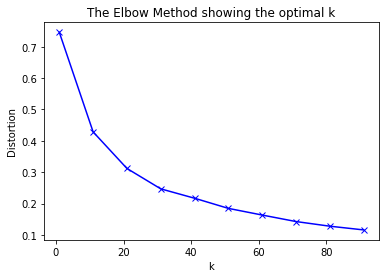

In [22]:
#range(1,100,10)
find_elbow(text)

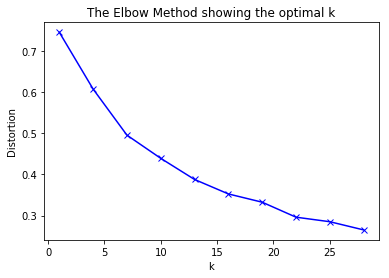

In [23]:
def find_elbow(doc_list):
    
    clf = svd(doc_list)
    
    distortions = []
    K = range(1,30,3)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, n_jobs=-1)
        kmeanModel.fit(clf)
        distortions.append(sum(np.min(cdist(clf, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / clf.shape[0])

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
find_elbow(text)

In [9]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), lowercase=True, max_features=1000) 
tfidf_model = vectorizer.fit_transform(text)

# less noise without SVD
# svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
# clf = svd.fit_transform(tfidf_model) 

kmeans = KMeans(n_clusters=20, n_init = 5, n_jobs = -1)
km = kmeans.fit_transform(tfidf_model)

In [10]:
words = vectorizer.get_feature_names()
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : enbrel, infection, category, wheel, joint, buzzer, applause, okay, excited, well
1 : johnson, neighborhood, black, smoker, yardecue, calvin, neighbor, nice meet, like, wood
2 : rain, shower, storm, temperature, wednesday, tomorrow, reporter, afternoon, morning, cloud
3 : game, right, going, time, back, ball, mike, football, like, team
4 : erin, york, york city, city, broadway, demarcus, star, trot, city night, week
5 : penn teller, penn, teller, applause, cheering applause, cheering, magician, birthday, heart, alyson
6 : blake, kelly, daly, dave, queen, queen kelly, country, artist, coach, jennifer
7 : elton, harry, singing, bradley, taron, guitar, star, harry style, cheryl, long time
8 : flag, relationship, know, someone, young, well, laugh, okay, actually, time
9 : judge, judy, judge judy, space, personal, milian, judge milian, list, plant, property
10 : steve, taryn, name something, survey said, answer, survey, name, steve name, said, laurence
11 : know, okay, right, yeah, like,

In [ ]:
kmeans_df = english
kmeans_df['cluster'] = kmeans.labels_
kmeans_df.head(1)

In [ ]:
#kmeans_df.to_csv('data/kmeans_clusters.csv', encoding='utf-8', index=False)

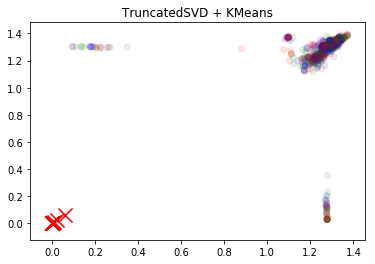

In [21]:
#this array is one dimesional so we plot using
plt.scatter(km[:,0], km[:,1], c='rgb', alpha=0.1)
centers2D = kmeans.cluster_centers_

plt.scatter(centers2D[:,0], centers2D[:,1], marker='x', s=200, linewidths=3, c='r')
plt.title('TruncatedSVD + KMeans')
plt.show() 

In [ ]:
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
clf = svd.fit_transform(tfidf_model) 

## LDA

In [ ]:
for c in text:
    tok = word_tokenize(text[1])
    dictionary = corpora.Dictionary([(str(tok).split())])
    corpus = [dictionary.doc2bow(t) for t in ([(str(tok).split())])]

In [ ]:
np.random.seed(seed=44)

tok = word_tokenize(text[1])
dictionary = corpora.Dictionary([(str(tok).split())])
corpus = [dictionary.doc2bow(t) for t in ([(str(tok).split())])]

# number of topics
K=3

# Run LDA model to extract topics
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=K, alpha='auto', passes=10)

In [ ]:
lda.show_topics(K, num_words=10, formatted=False)

In [ ]:
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis_data)

## LDA sklearn

In [12]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), lowercase=True, max_features=1000) 
tfidf_model = vectorizer.fit_transform(text)

lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_model = lda_tfidf.fit_transform(tfidf_model)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [13]:
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tfidf, tfidf_model, vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
16     77.411632        1       1 -0.028648 -0.003023
19      6.610930        1       2  0.253937  0.119981
8       3.362334        1       3 -0.105323  0.196524
6       3.007627        1       4  0.051897 -0.182365
3       1.807655        1       5 -0.168092  0.002893
12      0.902853        1       6  0.008023 -0.051776
7       0.815316        1       7 -0.014533 -0.035677
10      0.574624        1       8  0.000203 -0.011527
17      0.477813        1       9 -0.001926 -0.003482
1       0.457201        1      10  0.001669 -0.002710
5       0.457201        1      11  0.000476 -0.002826
4       0.457201        1      12  0.000330 -0.003068
15      0.457201        1      13  0.000229 -0.002975
11      0.457201        1      14  0.000669 -0.002900
2       0.457201        1      15  0.000122 -0.002693
9       0.457201        1      16  0.000396 -0.002926
13      0.457201        1      17 -0.000241 -0.002471
0       0.457201        1      18  0.000337 -0.003060
14      0.457201        1      19  0.000295 -0.002885
18      0.457201        1      20  0.000180 -0.003035, topic_info=     Category       Freq          Term      Total  loglift  logprob
term                                                               
808   Default  24.000000         steve  24.000000  30.0000  30.0000
706   Default  67.000000         right  67.000000  29.0000  29.0000
616   Default  52.000000          okay  52.000000  28.0000  28.0000
478   Default  61.000000          know  61.000000  27.0000  27.0000
948   Default  39.000000          well  39.000000  26.0000  26.0000
35    Default  33.000000      applause  33.000000  25.0000  25.0000
992   Default  24.000000          york  24.000000  24.0000  24.0000
986   Default  50.000000          yeah  50.000000  23.0000  23.0000
720   Default  25.000000          said  25.000000  22.0000  22.0000
504   Default  57.000000          like  57.000000  21.0000  21.0000
458   Default  13.000000         judge  13.000000  20.0000  20.0000
586   Default  18.000000          name  18.000000  19.0000  19.0000
526   Default  36.000000          love  36.000000  18.0000  18.0000
489   Default  30.000000         laugh  30.000000  17.0000  17.0000
366   Default  35.000000          good  35.000000  16.0000  16.0000
879   Default  35.000000          time  35.000000  15.0000  15.0000
927   Default  35.000000          want  35.000000  14.0000  14.0000
55    Default  30.000000          back  30.000000  13.0000  13.0000
363   Default  36.000000         going  36.000000  12.0000  12.0000
866   Default  32.000000         think  32.000000  11.0000  11.0000
519   Default  32.000000          look  32.000000  10.0000  10.0000
778   Default  19.000000     something  19.000000   9.0000   9.0000
176   Default  34.000000          come  34.000000   8.0000   8.0000
990   Default  27.000000          year  27.000000   7.0000   7.0000
320   Default  25.000000         first  25.000000   6.0000   6.0000
742   Default   9.000000       senator   9.000000   5.0000   5.0000
636   Default  27.000000        people  27.000000   4.0000   4.0000
865   Default  28.000000         thing  28.000000   3.0000   3.0000
691   Default  30.000000        really  30.000000   2.0000   2.0000
593   Default  25.000000          need  25.000000   1.0000   1.0000
...       ...        ...           ...        ...      ...      ...
218   Topic20   0.040647  dancing star   5.016066   0.5723  -6.8987
380   Topic20   0.040940          hair   7.231497   0.2137  -6.8915
237   Topic20   0.040635      designed   5.068039   0.5617  -6.8989
513   Topic20   0.040573         local   4.711331   0.6332  -6.9005
732   Topic20   0.040655         score   5.229824   0.5308  -6.8985
214   Topic20   0.040951        damage   8.435872   0.0599  -6.8912
349   Topic20   0.040779          gave   6.498228   0.3167  -6.8954
821   Topic20   0.040739         style   5.990324

In [ ]:
print("Sparcity: ", ((tfidf_model > 0).sum()/tfidf_model.size)*100, "%")
print("Log Likelihood: ", lda_tfidf.score(tfidf_model))
print("Perplexity: ", lda_tfidf.perplexity(tfidf_model))

Perplexity may not be the best measure to evaluate topic models because there is no consideration of the context and semantic associations between words.

## LDA GridSearch

In [ ]:
search_params = {'n_components': [3, 5, 8, 10], 'learning_decay': [.5]}

In [ ]:
search_params = {'n_components': [3, 5, 8, 10], 'learning_decay': [.5]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params)
model.fit(tfidf_model)
best_lda_model = model.best_estimator_

In [ ]:
best_lda_model = model.best_estimator_

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(tfidf_model))

In [16]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), lowercase=True, max_features=1000) 
tfidf_model = vectorizer.fit_transform(text)

best_lda_model = LatentDirichletAllocation(n_components=20, learning_decay=0.5, n_jobs=-1)
best_lda_model.fit(tfidf_model)

df_topic_keywords = pd.DataFrame(best_lda_model.components_)
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.head()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


,abc,abc com,ability,able,absolutely,across,action,actually,advice,afternoon,...,year,yesterday,york,york city,york city night,york city york,york welcome,york welcome york,young,yummy
0,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,...,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003
1,0.050004,0.050003,0.050005,0.050006,0.050003,0.050003,0.050003,0.050004,0.050003,0.050003,...,0.050008,0.050004,0.050004,0.050003,0.050002,0.050003,0.050003,0.050003,0.050005,0.050003
2,0.050003,0.050003,0.050003,0.050003,0.050002,0.050003,0.050003,0.050003,0.050003,0.050003,...,0.050003,0.050002,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003
3,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,...,0.050003,0.050003,0.050003,0.050004,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003
4,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,...,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003,0.050003


In [29]:
# Show top n keywords for each topic

def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
        
    return topic_keywords

In [ ]:
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)     

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords

Text(0.5,1,'LDA/KMeans Topic Clusters via 2 Component SVD')

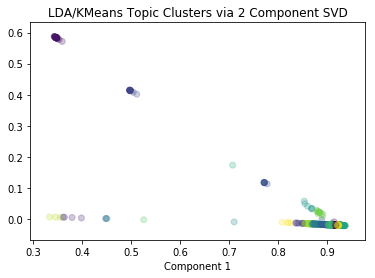

In [20]:
lda_output = best_lda_model.transform(tfidf_model)
clusters = KMeans(n_clusters=20, random_state=100, n_jobs=-1, verbose=False).fit_predict(lda_output)

svd_model = TruncatedSVD(n_components=5)
lda_output_svd = svd_model.fit_transform(lda_output)

plt.scatter(lda_output_svd[:, 0], lda_output_svd[:, 1], c=clusters, alpha=0.25)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("LDA/KMeans Topic Clusters via 2 Component SVD")

## LDA 50k Corpus

In [26]:
#check = pd.read_csv('data/clean_english.csv', encoding='utf-8')
check.describe()

,duration,tui
count,51973.0,5.197300e+04
mean,900000.0,2.547169e+08
std,0.0,2.127712e+07
min,900000.0,2.515332e+08
25%,900000.0,2.515362e+08
50%,900000.0,2.515387e+08
75%,900000.0,2.515463e+08
max,900000.0,4.106483e+08


In [34]:
check.tail(2)

,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url,date,text,cleaned,language
51971,{'$oid': '5bb414bcd525cb0008199ce6'},WITI_FOX_MILWAUKEE,{'$date': '2018-10-03T01:00:44.585Z'},900000,dflt,ENSWERCCR7_109_206,{'$numberLong': '1538527500000'},251538097,{'$date': '2018-10-03T00:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-03 01:00:44.585,1538527500747\n1568\nHe lives in the tunnels\n...,life tunnel nothing happens town know help mig...,en
51972,{'$oid': '5bb414bd2c1ba60007fe40cd'},WJW_HD_FOX,{'$date': '2018-10-03T01:00:45.028Z'},900000,dflt,ENSWERCCR7_8_3,{'$numberLong': '1538527500000'},251538186,{'$date': '2018-10-03T00:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-03 01:00:45.028,1538527500317\n1568\nHe lives in the tunnels\n...,life tunnel nothing happens town know help mig...,en


In [42]:
text = check['cleaned'].values
text = text.tolist()

pre = check['text'].values
pre = clean_for_spacy(pre)

#save pickled
# with open ('data/cluster_text.pkl', 'wb') as f:
#     pickle.dump(text, f)
    
# with open ('data/spacy_text.pkl', 'wb') as m:
#     pickle.dump(pre, m)
    
#open pickled
# with open ('data/cluster_text.pkl', 'rb') as f:
#     new_data = pickle.load(f)

In [36]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), lowercase=True, max_features=1000) 
tfidf_model = vectorizer.fit_transform(text)

best_lda_model = LatentDirichletAllocation(n_components=20, learning_decay=0.5, n_jobs=-1)
best_lda_model.fit(tfidf_model)

df_topic_keywords = pd.DataFrame(best_lda_model.components_)
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.head()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


,able,absolutely,access,accident,according,account,accused,across,action,actually,...,wrong,wrote,yard,yeah,yeah yeah,year,year year,yesterday,york,young
0,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,9.739568,0.05
1,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.05
2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.05
3,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.05
4,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.05


In [37]:
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)     

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
0,jerry,beep,harvey,kanye,cardi,friend,boyfriend,audience,married,justin,trump,video,girl,want want,club
1,applause cheer,stick,supreme court nominee,mathis,court nominee,cheer applause cheer,applause cheer applause,roll,reach,dangerous,eye,former,imagine,throw,wrong
2,applause cheer,stick,supreme court nominee,mathis,court nominee,cheer applause cheer,applause cheer applause,roll,reach,dangerous,eye,former,imagine,throw,wrong
3,mike,george,worker,mark,stuff,ball,round,value,lane,nick,building,last year,doug,team,player
4,applause cheer,stick,supreme court nominee,mathis,court nominee,cheer applause cheer,applause cheer applause,roll,reach,dangerous,eye,former,imagine,throw,wrong
5,reporter,rain,police,news,president,tonight,shower,say,year,county,storm,morning,area,temperature,tomorrow
6,applause cheer,stick,supreme court nominee,mathis,court nominee,cheer applause cheer,applause cheer applause,roll,reach,dangerous,eye,former,imagine,throw,wrong
7,applause cheer,stick,supreme court nominee,mathis,court nominee,cheer applause cheer,applause cheer applause,roll,reach,dangerous,eye,former,imagine,throw,wrong
8,like,know,right,yeah,okay,want,think,going,good,time,well,back,come,love,look
9,applause cheer,stick,supreme court nominee,mathis,court nominee,cheer applause cheer,applause cheer applause,roll,reach,dangerous,eye,former,imagine,throw,wrong


Text(0.5,1,'LDA/KMeans Topic Clusters via 2 Component SVD')

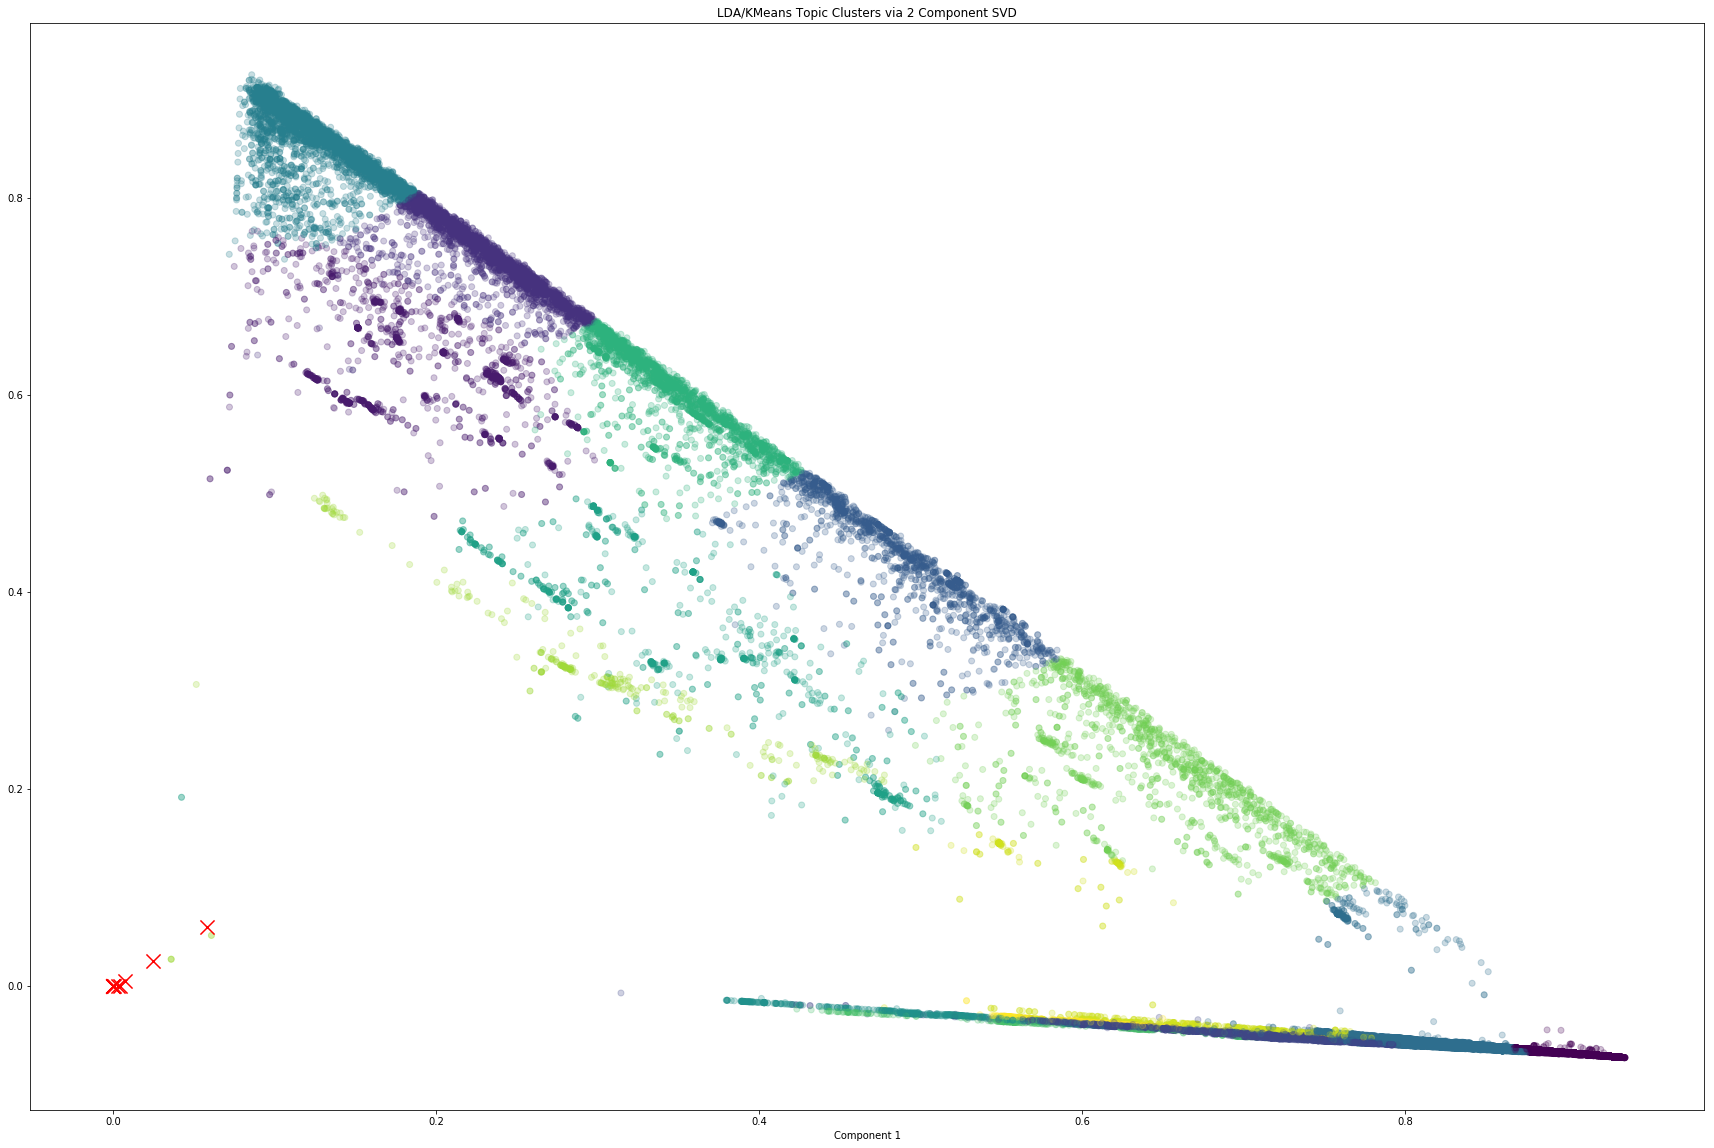

In [47]:
lda_output = best_lda_model.transform(tfidf_model)
clusters = KMeans(n_clusters=15, random_state=100, n_jobs=-1, verbose=False).fit_predict(lda_output)

svd_model = TruncatedSVD(n_components=5)
lda_output_svd = svd_model.fit_transform(lda_output)

#plt.scatter(km[:,0], km[:,1], c='rgb', alpha=0.1)
centers2D = kmeans.cluster_centers_


plt.figure(figsize=(30,20))

plt.scatter(lda_output_svd[:, 0], lda_output_svd[:, 1], c=clusters, alpha=0.25)
plt.scatter(centers2D[:,0], centers2D[:,1], marker='x', s=200, linewidths=3, c='r')
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("LDA/KMeans Topic Clusters via 2 Component SVD")

In [44]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), lowercase=True, max_features=1000) 
tfidf_model = vectorizer.fit_transform(text)

lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_model = lda_tfidf.fit_transform(tfidf_model)

pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tfidf, tfidf_model, vectorizer)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
10     35.306949        1       1 -0.167612  0.019215
15     19.559361        1       2 -0.167678 -0.006511
3      18.725508        1       3 -0.185401 -0.042276
5       7.152964        1       4 -0.179861 -0.038253
4       4.046213        1       5 -0.172134  0.019943
18      3.081033        1       6 -0.170146 -0.050608
2       2.453544        1       7 -0.012713  0.235018
1       1.523302        1       8 -0.142135  0.070616
14      1.063400        1       9 -0.097200  0.037023
13      0.842308        1      10  0.250981  0.088744
16      0.797115        1      11  0.090487 -0.121598
8       0.795038        1      12  0.133572  0.233863
12      0.703340        1      13  0.134468 -0.217412
17      0.645108        1      14  0.219418  0.274697
6       0.633162        1      15  0.262387 -0.119681
11      0.630770        1      16  0.259312 -0.197021
19      0.598026        1      17  0.082626  0.062813
0       0.502382        1      18  0.035473 -0.118074
9       0.492644        1      19 -0.018862 -0.098620
7       0.447833        1      20 -0.154981 -0.031878, topic_info=     Category         Freq             Term        Total  loglift  logprob
term                                                                      
586   Default  2348.000000         narrator  2348.000000  30.0000  30.0000
820   Default  2005.000000            steve  2005.000000  29.0000  29.0000
200   Default  1652.000000           credit  1652.000000  28.0000  28.0000
784   Default  1680.000000             skin  1680.000000  27.0000  27.0000
449   Default  2108.000000            judge  2108.000000  26.0000  26.0000
43    Default  2070.000000         applause  2070.000000  25.0000  25.0000
515   Default  2164.000000             look  2164.000000  24.0000  24.0000
716   Default  3321.000000            right  3321.000000  23.0000  23.0000
647   Default  1064.000000             phil  1064.000000  22.0000  22.0000
542   Default   919.000000            maury   919.000000  21.0000  21.0000
144   Default  1340.000000   cheer applause  1340.000000  20.0000  20.0000
143   Default  1347.000000            cheer  1347.000000  19.0000  19.0000
296   Default  1214.000000             feel  1214.000000  18.0000  18.0000
655   Default  1006.000000             plan  1006.000000  17.0000  17.0000
961   Default   776.000000            wendy   776.000000  16.0000  16.0000
873   Default  2277.000000            think  2277.000000  15.0000  15.0000
615   Default  2182.000000             okay  2182.000000  14.0000  14.0000
710   Default  1954.000000         reporter  1954.000000  13.0000  13.0000
600   Default  1286.000000            night  1286.000000  12.0000  12.0000
33    Default   863.000000        announcer   863.000000  11.0000  11.0000
546   Default   722.000000         medicare   722.000000  10.0000  10.0000
69    Default   783.000000        beautiful   783.000000   9.0000   9.0000
55    Default   867.000000         audience   867.000000   8.0000   8.0000
486   Default  1185.000000         laughter  1185.000000   7.0000   7.0000
413   Default   662.000000           humana   662.000000   6.0000   6.0000
61    Default  2214.000000             back  2214.000000   5.0000   5.0000
560   Default   606.000000           milian   606.000000   4.0000   4.0000
454   Default   599.000000     judge milian   599.000000   3.0000   3.0000
742   Default   655.000000            score   655.000000   2.0000   2.0000
709   Default   681.000000           report   681.000000   1.0000   1.0000
...       ...          ...              ...          ...      ...      ...
989   Topic20     2.344329            write   230.223384   0.8215  -6.9078
391   Topic20     2.344329             held   230.322662   0.8210  -6.9078
911   Topic20     2.344329            trump   878.325807  -0.5175  -6.9078
462   Topic20     2.344329            kelly   438.606117   0.1769  -6